## Лабораторная работа №3
    ФИО: Михайлов Александр Евгеньевич
    Группа: БИВТ-23-СП-1

### 1. Загрузка и анализ данных

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, classification_report, 
                           confusion_matrix, roc_auc_score, roc_curve, auc, 
                           precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_csv('student-mat.csv', sep=',')

### 2. Определение типа задачи машинного обучения

**Целевая переменная:** `G3` — итоговая оценка студентов (0-20 баллов)

**Тип задачи:** МНОГОКЛАССОВАЯ КЛАССИФИКАЦИЯ

**Обоснование:** 
- Предсказываем одну из 21 возможной категории (оценки от 0 до 20)
- Каждая оценка - это отдельный класс, а не непрерывное число
- Студент может получить только одну итоговую оценку

### 3. Предобработка данных

In [25]:
# Разделяем данные
X = data.drop('G3', axis=1)
y = data['G3']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# Проверяем пропуски
print(f"\nПропуски: Train {X_train.isnull().sum().sum()}, Test {X_test.isnull().sum().sum()}")

# Нормируем численные признаки
numerical = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 
             'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])


# Кодируем категориальные признаки
categorical = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
               'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
               'nursery', 'higher', 'internet', 'romantic']

X_train = pd.get_dummies(X_train, columns=categorical, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical, drop_first=True)

# Убеждаемся что столбцы совпадают
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0

X_test = X_test[X_train.columns]

print(f"\nФинальный размер: Train {X_train.shape}, Test {X_test.shape}")

print("\nПример обработанных данных (первые 3 студента, 10 признаков):")
print(X_train.iloc[:3])

Train: (316, 32), Test: (79, 32)

Пропуски: Train 0, Test 0

Финальный размер: Train (316, 41), Test (79, 41)

Пример обработанных данных (первые 3 студента, 10 признаков):
          age      Medu      Fedu  traveltime  studytime  failures    famrel  \
181 -0.586396  0.246437  0.423207   -0.625779  -0.056853 -0.456744  0.064432   
194 -0.586396 -0.680636  0.423207    0.828236  -1.254553 -0.456744  1.195575   
173 -0.586396 -1.607709  0.423207   -0.625779  -0.056853  3.628097  0.064432   

     freetime     goout     Dalc  ...  guardian_mother  guardian_other  \
181 -1.195981 -0.144396 -0.55443  ...             True           False   
194 -0.214345 -0.144396 -0.55443  ...            False           False   
173 -0.214345  1.644982 -0.55443  ...             True           False   

     schoolsup_yes  famsup_yes  paid_yes  activities_yes  nursery_yes  \
181          False       False      True            True         True   
194          False       False     False           False       

### 4. Обучение моделей на тренировочном множестве

In [28]:
#  Линейная модель 
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train, y_train)

# Деревянная модель 
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# K-ближайших соседей
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Случайный лес 
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Оценка качества
print("РЕЗУЛЬТАТЫ")
print("Модель | Точность на обучении | Точность на тесте")
print("-------|----------------------|--------------------")

models = {
    'LogisticRegression': log_reg,
    'DecisionTree': tree, 
    'KNeighbors': knn,
    'RandomForest': rf
}

for name, model in models.items():
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    print(f"{name:20} | {train_acc:.3f}    | {test_acc:.3f}")

РЕЗУЛЬТАТЫ
Модель | Точность на обучении | Точность на тесте
-------|----------------------|--------------------
LogisticRegression   | 0.842    | 0.329
DecisionTree         | 1.000    | 0.253
KNeighbors           | 0.554    | 0.329
RandomForest         | 1.000    | 0.405


### 5. Расчет метрик на train и test множествах


ТАБЛИЦА МЕТРИК:
            Модель  Accuracy Train  Accuracy Test  F1 Train  F1 Test  ROC-AUC Train  ROC-AUC Test
LogisticRegression           0.842          0.329     0.841    0.317          0.984         0.895
      DecisionTree           1.000          0.253     1.000    0.249          1.000         0.595
        KNeighbors           0.554          0.329     0.537    0.303          0.944         0.791
      RandomForest           1.000          0.405     1.000    0.367          1.000         0.891


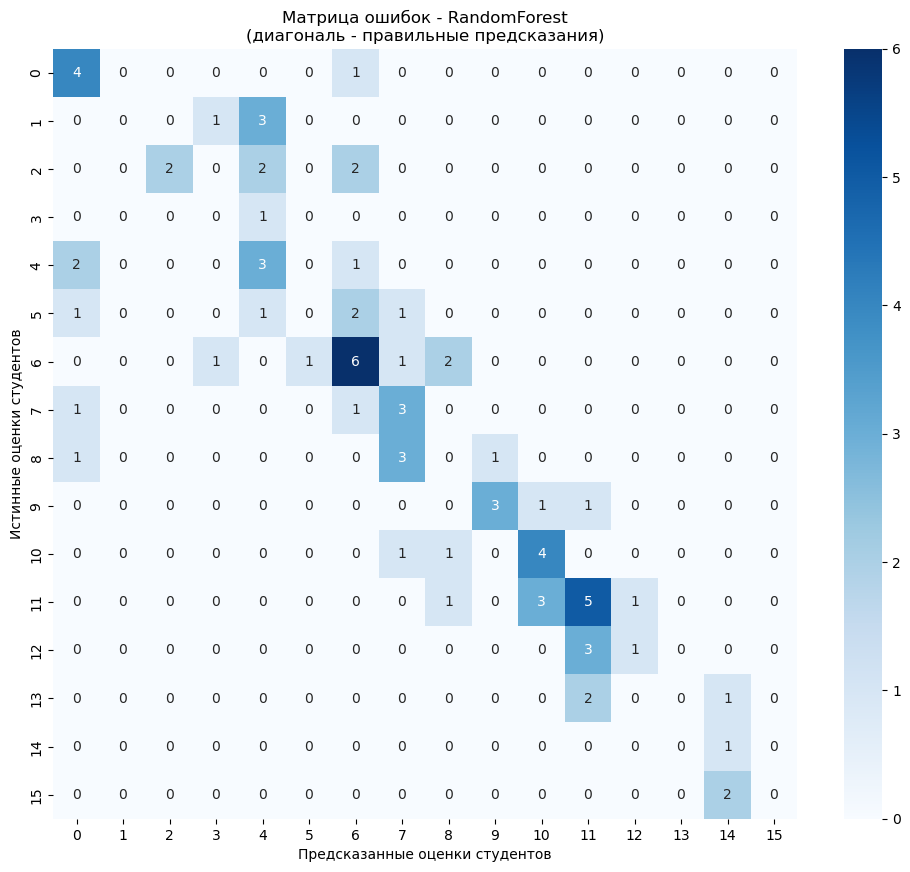

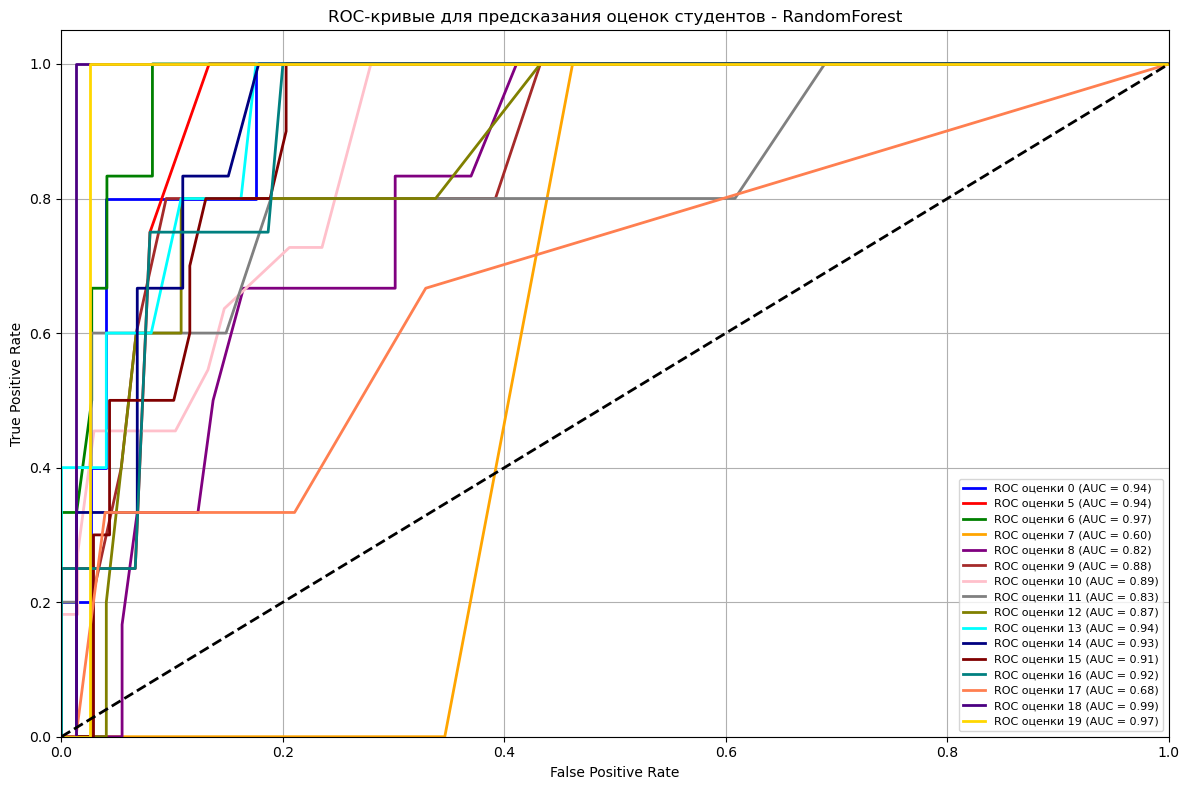

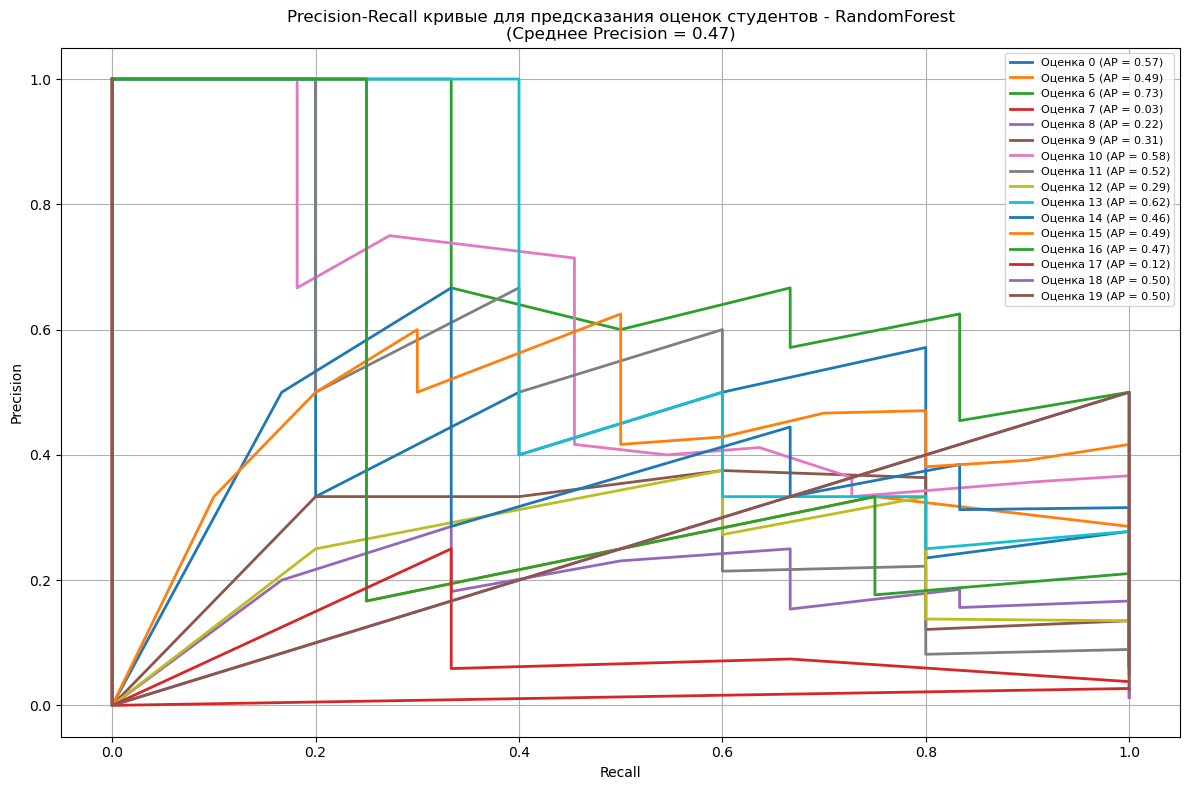

In [31]:
# # Создаем таблицу для результатов
# results = []

# # Для каждой модели считаем метрики
# for name, model in models.items():
#     # Предсказания
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)
    
#     # Метрики
#     train_acc = accuracy_score(y_train, y_train_pred)
#     test_acc = accuracy_score(y_test, y_test_pred)
#     train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
#     test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    
#     # Сохраняем результаты
#     results.append({
#         'Модель': name,
#         'Accuracy Train': round(train_acc, 3),
#         'Accuracy Test': round(test_acc, 3),
#         'F1 Train': round(train_f1, 3),
#         'F1 Test': round(test_f1, 3)
#     })

# # Находим лучшую модель
# best_test_acc = max([r['Accuracy Test'] for r in results])
# best_model_name = [r['Модель'] for r in results if r['Accuracy Test'] == best_test_acc][0]
# best_model = models[best_model_name]
# y_pred = best_model.predict(X_test)



# # Основная таблица результатов
# results_df = pd.DataFrame(results)
# print("\nТАБЛИЦА МЕТРИК:")
# print(results_df.to_string(index=False))

# # Матрица ошибок лучшей модели
# plt.figure()
# cm = confusion_matrix(y_test, y_pred)
# sns.heatmap(cm, annot=True, fmt='d')
# plt.title(f'Матрица ошибок - {best_model_name}\n(диагональ - правильные предсказания)')
# plt.ylabel('Истинные оценки')
# plt.xlabel('Предсказанные оценки')
# plt.show()
# Создаем таблицу для результатов
# Создаем таблицу для результатов
results = []

# Для каждой модели считаем метрики
for name, model in models.items():
    # Предсказания
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Метрики для классификации
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    
    # ROC-AUC (для многоклассовой классификации)
    train_auc = 0
    test_auc = 0
    
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train)
        y_test_proba = model.predict_proba(X_test)
        
        # Получаем все возможные классы из обучающей выборки
        all_classes = np.unique(y_train)
        
        # Для train
        try:
            train_auc = roc_auc_score(y_train, y_train_proba, multi_class='ovr', average='weighted')
        except:
            train_auc = 0
        
        # Для test - используем только классы, которые есть и в модели и в тесте
        unique_test_classes = np.unique(y_test)
        available_classes = [cls for cls in unique_test_classes if cls in all_classes]
        
        if len(available_classes) > 1:
            try:
                # Создаем бинаризованные метки только для доступных классов
                y_test_bin = label_binarize(y_test, classes=available_classes)
                
                # Получаем индексы доступных классов в вероятностях
                class_indices = [np.where(all_classes == cls)[0][0] for cls in available_classes]
                test_auc = roc_auc_score(y_test_bin, y_test_proba[:, class_indices], 
                                       multi_class='ovr', average='weighted')
            except:
                test_auc = 0
    
    # Сохраняем результаты
    results.append({
        'Модель': name,
        'Accuracy Train': round(train_acc, 3),
        'Accuracy Test': round(test_acc, 3),
        'F1 Train': round(train_f1, 3),
        'F1 Test': round(test_f1, 3),
        'ROC-AUC Train': round(train_auc, 3),
        'ROC-AUC Test': round(test_auc, 3)
    })

# Находим лучшую модель
best_test_acc = max([r['Accuracy Test'] for r in results])
best_model_name = [r['Модель'] for r in results if r['Accuracy Test'] == best_test_acc][0]
best_model = models[best_model_name]
y_pred = best_model.predict(X_test)

# Основная таблица результатов
results_df = pd.DataFrame(results)
print("\nТАБЛИЦА МЕТРИК:")
print(results_df.to_string(index=False))

# Матрица ошибок лучшей модели
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Матрица ошибок - {best_model_name}\n(диагональ - правильные предсказания)')
plt.ylabel('Истинные оценки студентов')
plt.xlabel('Предсказанные оценки студентов')
plt.show()

# ROC-кривая для лучшей модели (если поддерживает вероятности)
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)
    
    # Получаем все классы из обучающей выборки
    all_classes = np.unique(y_train)
    
    # Используем только классы, присутствующие в тестовой выборке и доступные в модели
    unique_test_classes = np.unique(y_test)
    available_classes = [cls for cls in unique_test_classes if cls in all_classes]
    
    if len(available_classes) > 1:
        y_test_bin = label_binarize(y_test, classes=available_classes)
        n_classes = y_test_bin.shape[1]
        
        # Получаем индексы доступных классов в вероятностях
        class_indices = [np.where(all_classes == cls)[0][0] for cls in available_classes]
        
        # Вычисляем ROC-кривую для каждого класса
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, class_indices[i]])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Рисуем ROC-кривые
        plt.figure(figsize=(12, 8))
        colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 
                  'navy', 'maroon', 'teal', 'coral', 'indigo', 'gold', 'lightblue', 'darkgreen', 'salmon', 'plum', 'khaki']
        
        for i, color in zip(range(n_classes), colors):
            if i < len(colors):
                plt.plot(fpr[i], tpr[i], color=color, lw=2,
                        label='ROC оценки {0} (AUC = {1:0.2f})'.format(available_classes[i], roc_auc[i]))
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC-кривые для предсказания оценок студентов - {best_model_name}')
        plt.legend(loc="lower right", fontsize=8)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Precision-Recall кривая для лучшей модели
if hasattr(best_model, "predict_proba") and len(available_classes) > 1:
    
    # Среднее precision по всем классам
    average_precision = average_precision_score(y_test_bin, y_proba[:, class_indices], average='weighted')
    
    # Precision-Recall для каждого класса
    precision = dict()
    recall = dict()
    
    plt.figure(figsize=(12, 8))
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, class_indices[i]])
        ap_score = average_precision_score(y_test_bin[:, i], y_proba[:, class_indices[i]])
        plt.plot(recall[i], precision[i], lw=2,
                label='Оценка {0} (AP = {1:0.2f})'.format(available_classes[i], ap_score))
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall кривые для предсказания оценок студентов - {best_model_name}\n(Среднее Precision = {average_precision:.2f})')
    plt.legend(loc="best", fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### 6. Сравнение моделей и анализ результатов


СРАВНЕНИЕ МОДЕЛЕЙ ПРЕДСКАЗАНИЯ УСПЕВАЕМОСТИ СТУДЕНТОВ:
RandomForest         | Train: 1.000 | Test: 0.405 | Сильное переобучение
LogisticRegression   | Train: 0.842 | Test: 0.329 | Сильное переобучение
KNeighbors           | Train: 0.554 | Test: 0.329 | Переобучение
DecisionTree         | Train: 1.000 | Test: 0.253 | Сильное переобучение

ЛУЧШАЯ МОДЕЛЬ: RandomForest
Точность на тесте: 40.5%


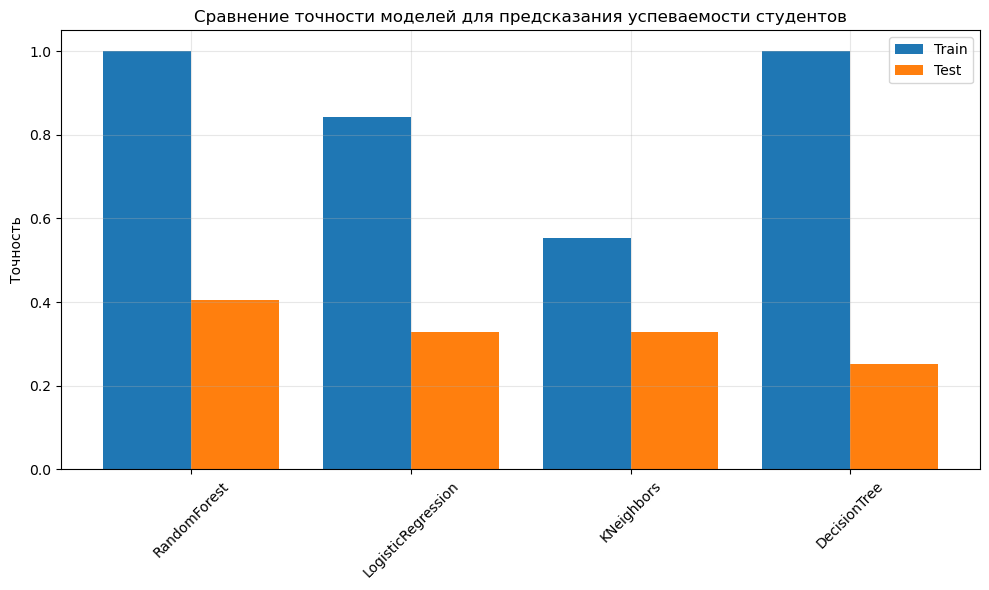


ОТВЕТЫ НА ВОПРОСЫ

1. Какая модель справилась лучше с поставленной задачей?
RandomForest - показывает наилучшую точность на тестовых данных (40.5%)

2. Имеет ли место переобучение?
Да, 4 из 4 моделей демонстрируют переобучение
   - RandomForest: разница train-test = 0.595
   - LogisticRegression: разница train-test = 0.513
   - KNeighbors: разница train-test = 0.225
   - DecisionTree: разница train-test = 0.747

3. Имеет ли место недообучение?
Нет, все модели показывают приемлемую точность на тестовых данных

4. Как можно улучшить метрики моделей?
Основная проблема - переобучение:
- Уменьшить сложность моделей (глубину деревьев, регуляризацию)
- Увеличить размер обучающей выборки
- Применить feature selection для образовательных признаков


In [32]:
# Создаем таблицу для сравнения
comparison = []

for result in results:
    model_name = result['Модель']
    train_acc = result['Accuracy Train']
    test_acc = result['Accuracy Test']
    
    # Считаем разницу между train и test
    diff = train_acc - test_acc
    
    # Определяем уровень переобучения
    if diff > 0.3:
        status = "Сильное переобучение"
    elif diff > 0.15:
        status = "Переобучение" 
    else:
        status = "Норма"
    
    comparison.append({
        'Модель': model_name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Разница': diff,
        'Статус': status
    })

# Сортируем по точности на тесте (от лучшей к худшей)
comparison.sort(key=lambda x: x['Test Accuracy'], reverse=True)

# Выводим таблицу
print("\nСРАВНЕНИЕ МОДЕЛЕЙ ПРЕДСКАЗАНИЯ УСПЕВАЕМОСТИ СТУДЕНТОВ:")
print("="*75)
for model in comparison:
    print(f"{model['Модель']:20} | Train: {model['Train Accuracy']:.3f} | Test: {model['Test Accuracy']:.3f} | {model['Статус']}")

# Находим лучшую модель
best_model = comparison[0]
print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model['Модель']}")
print(f"Точность на тесте: {best_model['Test Accuracy']:.1%}")

# График
plt.figure(figsize=(10, 6))
models = [m['Модель'] for m in comparison]
train_scores = [m['Train Accuracy'] for m in comparison]
test_scores = [m['Test Accuracy'] for m in comparison]

x = range(len(models))
plt.bar(x, train_scores, width=0.4, label='Train')
plt.bar([i + 0.4 for i in x], test_scores, width=0.4, label='Test')

plt.xticks([i + 0.2 for i in x], models, rotation=45)
plt.ylabel('Точность')
plt.title('Сравнение точности моделей для предсказания успеваемости студентов')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Ответы на вопросы
print("\n" + "="*50)
print("ОТВЕТЫ НА ВОПРОСЫ")
print("="*50)

# Автоматическое определение лучших моделей
best_test_score = max([m['Test Accuracy'] for m in comparison])
best_models = [m['Модель'] for m in comparison if m['Test Accuracy'] == best_test_score]

print(f"\n1. Какая модель справилась лучше с поставленной задачей?")
if len(best_models) == 1:
    print(f"{best_models[0]} - показывает наилучшую точность на тестовых данных ({best_test_score:.1%})")
else:
    print(f"{', '.join(best_models)} - показывают наилучшую точность на тестовых данных ({best_test_score:.1%})")

print(f"\n2. Имеет ли место переобучение?")
overfitted_models = [m for m in comparison if m['Статус'] != "Норма"]
if overfitted_models:
    print(f"Да, {len(overfitted_models)} из {len(comparison)} моделей демонстрируют переобучение")
    for model in overfitted_models:
        print(f"   - {model['Модель']}: разница train-test = {model['Разница']:.3f}")
else:
    print(f"Нет, все модели демонстрируют хорошую сходимость результатов на train и test")

print(f"\n3. Имеет ли место недообучение?")
low_performers = [m for m in comparison if m['Test Accuracy'] < 0.25]
if low_performers:
    print(f"Да, {len(low_performers)} моделей показывают низкую точность (<25%):")
    for model in low_performers:
        print(f"   - {model['Модель']}: точность = {model['Test Accuracy']:.1%}")
else:
    print(f"Нет, все модели показывают приемлемую точность на тестовых данных")

print(f"\n4. Как можно улучшить метрики моделей?")
# Автоматическая рекомендация на основе анализа
max_diff = max([m['Разница'] for m in comparison])
avg_accuracy = np.mean([m['Test Accuracy'] for m in comparison])

if max_diff > 0.2:
    print(f"Основная проблема - переобучение:")
    print(f"- Уменьшить сложность моделей (глубину деревьев, регуляризацию)")
    print(f"- Увеличить размер обучающей выборки")
    print(f"- Применить feature selection для образовательных признаков")
elif avg_accuracy < 0.7:
    print(f"Основная проблема - низкая точность:")
    print(f"- Подбор гиперпараметров с помощью GridSearchCV")
    print(f"- Использование ансамблевых методов (Gradient Boosting)")
    print(f"- Анализ важности признаков (семейные, социальные, образовательные)")
    print(f"- Балансировка классов (если есть редкие оценки)")
    print(f"- Добавление новых признаков (посещаемость, активность и др.)")
else:
    print(f"Модели показывают хорошие результаты. Для дальнейшего улучшения:")
    print(f"- Проверить данные на наличие целевой утечки")
    print(f"- Использовать кросс-валидацию для надежной оценки")
    print(f"- Проанализировать ошибки модели - какие оценки путаются")
    print(f"- Исследовать влияние социальных и семейных факторов на успеваемость")